In [1]:
import sys
import os
import matplotlib.pyplot as plt
import torch
# Add the src directory to the path. TEMPORARY FIX
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../..")))

from models.deeplab.deeplab import DeepLabV3
from src.models.data_management.cnn_formes import CNNFormes
from src.data_processing.dataset_loader import CoastData
from src.models.metrics import Metrics

from src.models.data_management.data_loader import DataLoaderManager

import cv2

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


(array([0, 1], dtype=uint8), array([65346,   190]))
(array([0., 1.], dtype=float32), array([63639,  1897]))


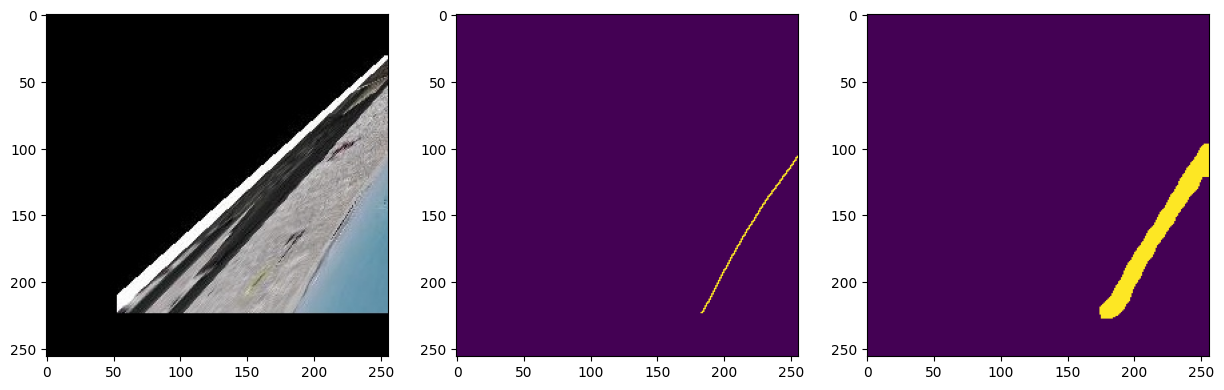

In [2]:
import numpy as np
artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../../artifacts/"))
data = DataLoaderManager.load_data(os.path.abspath(os.path.join(os.getcwd(), "../../../data/patchify_shoreline/")))
index = 0
img_path = data["test"]['images'][index]
mask_path = data["test"]['masks'][index]

model = DeepLabV3(num_classes=1, experiment_name="test_experiments", use_mlflow=False)
model.load_model(os.path.abspath(os.path.join(artifact_path, "2025-03-21-16-10-53_binary_deeplabv3+/models/best_model.pth")))

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

pred = model.predict(img_path)

print(np.unique(mask, return_counts=True))
print(np.unique(pred.cpu(), return_counts=True))


fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img)
ax[1].imshow(mask)
ax[2].imshow(pred.cpu().squeeze())

plt.show()

In [3]:
artifact_path = os.path.abspath(os.path.join(os.getcwd(), "../../../artifacts/"))

num_classes = 1
metrics = {
    "train": Metrics(phase="train", num_classes=num_classes, average=None, use_margin=False),
    "validation": Metrics(phase="val", num_classes=num_classes, average=None, use_margin=False),
    "test": Metrics(phase="test", num_classes=num_classes, average=None, use_margin=False) # 'macro'
}

# Load the data to split it and save it to a dict
model  = DeepLabV3(num_classes=1, experiment_name="test_experiments", use_mlflow=False, pretrained=False)

model.load_model(os.path.abspath(os.path.join(artifact_path, "2025-03-21-16-10-53_binary_deeplabv3+/models/best_model.pth")))

data_path = os.path.abspath(os.path.join(os.getcwd(), "../../../data/processed_shoreline"))

coast_data = CoastData(data_path)
split = coast_data.split_data()

data = DataLoaderManager.load_data(split)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


CoastData: global - 1717 images
Coast: agrelo, Total size: 244
Coast: arenaldentem, Total size: 40
Coast: cadiz, Total size: 946
Coast: cies, Total size: 430
Coast: samarador, Total size: 57


In [4]:
for split in data:
    print(f"Split: {split}")
    
    for img_path, mask_path in zip(data[split]["images"], data[split]["masks"]):
        pred = model.predict_patch(img_path, combination="max")
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = torch.from_numpy(mask).float() 
        metrics[split].update_metrics(pred, mask)

    metrics[split].compute()
    print(metrics[split].get_last_epoch_info())

Split: train
train metrics: 
	train_accuracy: 0.9479398727416992
	train_f1_score: 0.07214786857366562
	train_precision: 0.037493057548999786
	train_recall: 0.9530765414237976
	train_confusion_matrix: 
		0.9479 0.0521
		0.0469 0.9531

Split: validation
val metrics: 
	val_accuracy: 0.9481872320175171
	val_f1_score: 0.06949219852685928
	val_precision: 0.03612406179308891
	val_recall: 0.9108895063400269
	val_confusion_matrix: 
		0.9483 0.0517
		0.0891 0.9109

Split: test
test metrics: 
	test_accuracy: 0.9442967176437378
	test_f1_score: 0.06505686044692993
	test_precision: 0.033741094172000885
	test_recall: 0.9050710201263428
	test_confusion_matrix: 
		0.9444 0.0556
		0.0949 0.9051



/srv/Shoreline-extraction/data/processed_shoreline/images/1625428979.Sun.Jul.04_21_02_59.CET.2021.cadiz.image.jpg


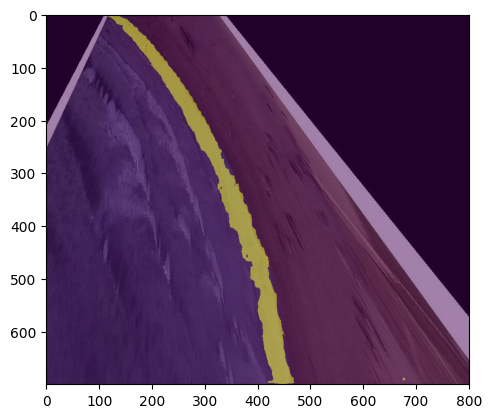

In [5]:
img_path = sorted(data['test']['images'])[85] # 85
print(img_path)

pred = model.predict_patch(img_path, combination="avg", patch_size = 256, stride = 128)

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
# plt.show()
plt.imshow(pred, alpha = 0.5)
plt.show()